In [197]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
shap.initjs()
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay, precision_recall_curve, PrecisionRecallDisplay, f1_score, make_scorer, accuracy_score
from sklearn.inspection import permutation_importance

## Датасет музыкальных композиций

In [51]:
# Максимальное количество отображаемых столбцов
pd.set_option('display.max_columns', 13)
# Максимальное количество отображаемых строк
pd.set_option('display.max_rows', 10)
# Максимальная ширина столбца
pd.set_option('display.max_colwidth', 45)
# Максимальная ширина отображения
pd.set_option('display.width', 80)

In [5]:
df = pd.read_csv("light_music.csv")
df_train, df_test = train_test_split(df, train_size=0.8, random_state=1)
y_train, y_test = df_train['popularity'], df_test['popularity']
df_train.drop(columns='popularity', inplace=True)
df_test.drop(columns='popularity', inplace=True)
df_train

,duration_ms,explicit,danceability,energy,key,loudness,...,instrumentalness,liveness,valence,tempo,time_signature,track_genre
1233,195456,False,0.648,0.473,0,-14.604,...,0.917000,0.136,0.363,112.998,4,electro
1056,176561,False,0.723,0.809,7,-3.081,...,0.001230,0.565,0.274,98.007,4,electro
1686,185474,False,0.568,0.669,2,-5.698,...,0.000000,0.115,0.405,149.969,4,electro
187,205280,False,0.736,0.722,10,-5.908,...,0.000074,0.137,0.448,112.921,4,blues
3840,160801,False,0.533,0.930,1,-4.208,...,0.000000,0.790,0.435,92.591,4,punk-rock
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2895,157648,False,0.480,0.369,7,-8.766,...,0.000000,0.100,0.548,159.687,4,pop
2763,245016,False,0.531,0.790,10,-7.213,...,0.000000,0.301,0.339,79.942,4,pop
905,237659,False,0.429,0.575,3,-7.626,...,0.003530,0.102,0.155,139.965,4,blues
3980,235253,False,0.481,0.715,11,-4.729,...,0.000000,0.243,0.818,135.802,4,punk-rock


In [6]:
Enc = OrdinalEncoder()
Enc.fit(df_train[['explicit', 'track_genre']])

OrdinalEncoder()

In [7]:
Enc.categories_

[array([False,  True]),
 array(['blues', 'electro', 'pop', 'punk-rock', 'spanish'], dtype=object)]

In [8]:
df_train[['explicit', 'track_genre']] = Enc.transform(df_train[['explicit', 'track_genre']])
df_test[['explicit', 'track_genre']] = Enc.transform(df_test[['explicit', 'track_genre']])

In [9]:
df_train

,duration_ms,explicit,danceability,energy,key,loudness,...,instrumentalness,liveness,valence,tempo,time_signature,track_genre
1233,195456,0.0,0.648,0.473,0,-14.604,...,0.917000,0.136,0.363,112.998,4,1.0
1056,176561,0.0,0.723,0.809,7,-3.081,...,0.001230,0.565,0.274,98.007,4,1.0
1686,185474,0.0,0.568,0.669,2,-5.698,...,0.000000,0.115,0.405,149.969,4,1.0
187,205280,0.0,0.736,0.722,10,-5.908,...,0.000074,0.137,0.448,112.921,4,0.0
3840,160801,0.0,0.533,0.930,1,-4.208,...,0.000000,0.790,0.435,92.591,4,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2895,157648,0.0,0.480,0.369,7,-8.766,...,0.000000,0.100,0.548,159.687,4,2.0
2763,245016,0.0,0.531,0.790,10,-7.213,...,0.000000,0.301,0.339,79.942,4,2.0
905,237659,0.0,0.429,0.575,3,-7.626,...,0.003530,0.102,0.155,139.965,4,0.0
3980,235253,0.0,0.481,0.715,11,-4.729,...,0.000000,0.243,0.818,135.802,4,3.0


In [24]:
y_train_bin = y_train.copy()
for i in range(len(y_train_bin)): y_train_bin.iloc[i] = 1 if (y_train.iloc[i] > 50) else 0
y_test_bin = y_test.copy()
for i in range(len(y_test_bin)): y_test_bin.iloc[i] = 1 if (y_test.iloc[i] > 50) else 0

In [25]:
print(f'Ratio of classes in y_train_bin: \n{y_train_bin.value_counts()} \n')
print(f'Ratio of classes in y_test_bin: \n{y_test_bin.value_counts()}')

Ratio of classes in y_train_bin: 
0    2373
1    1627
Name: popularity, dtype: int64 

Ratio of classes in y_test_bin: 
0    599
1    401
Name: popularity, dtype: int64


### 1 и 2 задания
Построение метрики ROC для случайного леса:

In [38]:
RanForClass = RandomForestClassifier(random_state=1)
RanForClass.fit(df_train, y_train_bin)

RandomForestClassifier(random_state=1)

In [39]:
roc_curve(y_test_bin, RanForClass.predict(df_test))

(array([0.        , 0.14357262, 1.        ]),
 array([0.        , 0.65835411, 1.        ]),
 array([2, 1, 0], dtype=int64))

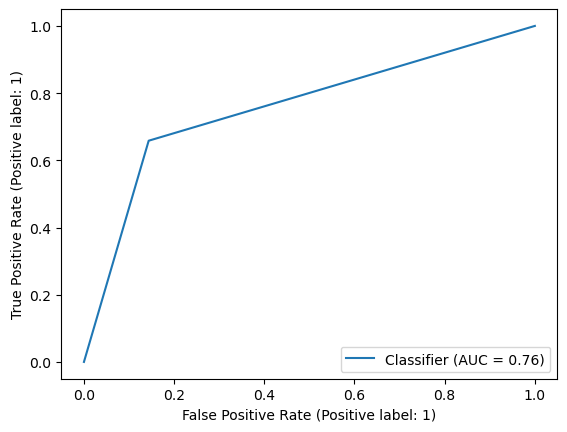

In [46]:
RocCurveDisplay.from_predictions(y_test_bin, RanForClass.predict(df_test))

In [41]:
RanForClass1 = RandomForestClassifier(random_state=1)
RanForClass1.fit(df_train, y_train_bin)
RanForClass2 = RandomForestClassifier(max_depth=5, random_state=1)
RanForClass2.fit(df_train, y_train_bin)

RandomForestClassifier(max_depth=5, random_state=1)

0.10795215633703714


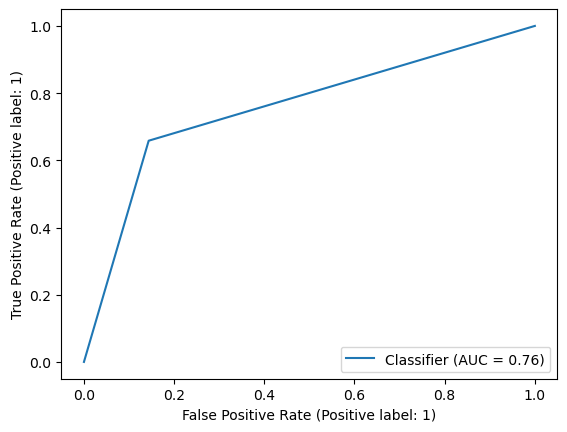

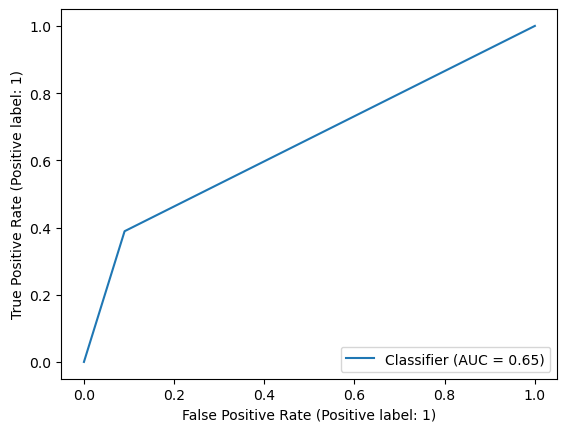

In [198]:
RocCurveDisplay.from_predictions(y_test_bin, RanForClass1.predict(df_test))
RocCurveDisplay.from_predictions(y_test_bin, RanForClass2.predict(df_test))
print(roc_auc_score(y_test_bin, RanForClass1.predict(df_test)) - roc_auc_score(y_test_bin, RanForClass2.predict(df_test)))

### 3 и 4 задания
Построение метрики PR для случайного леса:

In [85]:
precision, recall, _ = precision_recall_curve(y_test_bin, RanForClass1.predict(df_test))
print(precision)
print(recall)
print(_)

[0.401      0.75428571 1.        ]
[1.         0.65835411 0.        ]
[0 1]


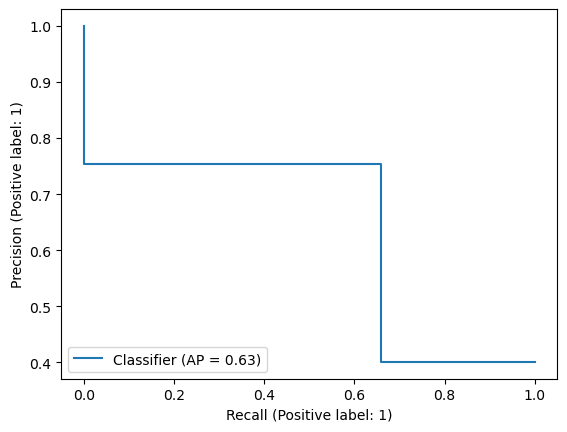

In [56]:
PrecisionRecallDisplay.from_predictions(y_test_bin, RanForClass1.predict(df_test))

In [84]:
print('f1 scores:')
list(map(lambda x, y: 2 * x * y / (x + y), (precision[0], precision[0], precision[1], precision[1], precision[2]), (recall[0], recall[1], recall[1], recall[2], recall[2])))

f1 scores:


[0.5724482512491078, 0.4984169057982443, 0.7030625832223703, 0.0, 0.0]

In [200]:
precision, recall, _ = precision_recall_curve(y_train_bin, RanForClass1.predict(df_train))
print(precision)
print(recall)

[0.40675    0.99383097 1.        ]
[1.         0.99016595 0.        ]


### 5 задание
Подбор оптимальных параметров с помощью кросс-валидации:

In [100]:
f1_scores = []
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
for n in range(60, 141, 10):
    RFC_n = RandomForestClassifier(n_estimators=n, random_state=1)
    f1_scores.append(cross_val_score(RFC_n, df_train, y_train_bin, cv=skf, scoring=make_scorer(f1_score)))

In [102]:
f1_avg = list(map(np.mean, f1_scores))

In [103]:
f1_avg

[0.6534908748096797,
 0.6607563035174451,
 0.6656717991593855,
 0.66317860455919,
 0.6649994835063466,
 0.6679659728077445,
 0.663546871812319,
 0.6690293311230802,
 0.6684697190669528]

In [105]:
print(f'Best f1_score comes with n_enumerators = {60 + np.argmax(f1_avg)*10}, f1 = {np.max(f1_avg)}')

Best f1_score comes with n_enumerators = 130, f1 = 0.6690293311230802


In [106]:
RFC = RandomForestClassifier(n_estimators=130, random_state=1)
RFC.fit(df_train, y_train_bin)

RandomForestClassifier(n_estimators=130, random_state=1)

Precision: [0.401      0.75428571 1.        ]
Recall: [1.         0.65835411 0.        ]


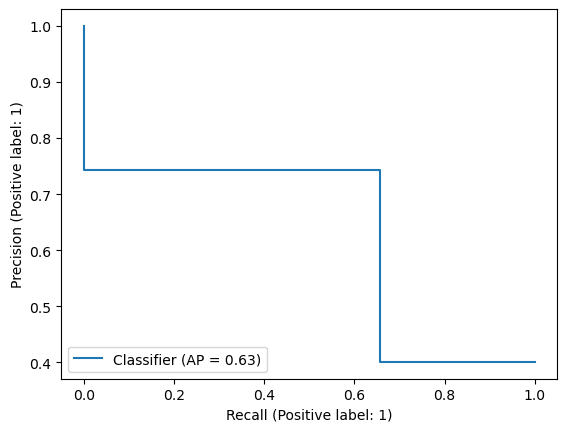

In [110]:
PrecisionRecallDisplay.from_predictions(y_test_bin, RFC.predict(df_test))
precision, recall, _ = precision_recall_curve(y_test_bin, RanForClass1.predict(df_test))
print(f'Precision: {precision}')
print(f'Recall: {recall}')

In [111]:
print('f1 scores:')
list(map(lambda x, y: 2 * x * y / (x + y), (precision[0], precision[0], precision[1], precision[1], precision[2]), (recall[0], recall[1], recall[1], recall[2], recall[2])))

f1 scores:


[0.5724482512491078, 0.4984169057982443, 0.7030625832223703, 0.0, 0.0]

### 6 задание
Создание своей реализации подсчета метрики по кросс-валидации:

In [117]:
def my_cross_val_score(model, X, y, cv, scoring='accuracy'):
    if isinstance(X, pd.DataFrame):
        X = X.copy().values  # перевод таблицы в numpy array
    if isinstance(y, pd.DataFrame) or isinstance(y, pd.Series):
        y = y.copy().values  # перевод целевого признака в numpy array
    
    scores = []
    for i, (train_idx, test_idx) in enumerate(cv.split(X, y)):  # получаем итеративно индексы для обучения и для валидации
        model.fit(X[train_idx], y[train_idx])  # обучаем модель на объектах для обучения
        preds = model.predict(X[test_idx])  # делаем предсказания на объектах для валидации
        if scoring == 'accuracy':  # считаем метрики на объектах для валидации
            score = accuracy_score(y[test_idx], preds)
        elif scoring == 'f1':
            score = f1_score(y[test_idx], preds)
        scores.append(score)  # добавляем метрику в список
    return np.array(scores)  # возвращаем np.array с метриками

In [120]:
skf =  StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

model_rf = RandomForestClassifier(n_estimators=130,
                                 random_state=1)
res = my_cross_val_score(model_rf, df_train, y_train_bin, skf, 'f1')  # вызов функции
print(f'Average metric: {np.mean(res)}')

Average metric: 0.6690293311230802


### 7 задание
Оценка вклада признаков в задачу с помощью Permutation Importance:

In [123]:
RFC = RandomForestClassifier(n_estimators=130, random_state=1)
RFC.fit(df_train, y_train_bin)
PI = permutation_importance(RFC, df_train, y_train_bin, scoring=make_scorer(f1_score), random_state=1)
PI

{'importances_mean': array([ 0.03416222,  0.00218089,  0.0164219 ,  0.02913621,  0.00345063,
         0.03903383,  0.00080548,  0.0089828 ,  0.02066682,  0.00869577,
         0.03388336,  0.03953857,  0.01423032, -0.00018611,  0.18382755]),
 'importances_std': array([1.15716697e-03, 3.08006284e-06, 1.63457938e-03, 3.02619510e-03,
        9.75439413e-04, 2.78110527e-03, 3.72238702e-04, 1.44927996e-03,
        3.15193521e-03, 1.70420178e-03, 1.93604994e-03, 2.93725799e-03,
        1.35892643e-03, 2.48133838e-04, 4.28333509e-03]),
 'importances': array([[ 0.03209532,  0.03514704,  0.03438909,  0.03530957,  0.03387007],
        [ 0.0021834 ,  0.00217712,  0.0021834 ,  0.00217712,  0.0021834 ],
        [ 0.01561223,  0.01923966,  0.01556827,  0.01714254,  0.01454682],
        [ 0.02697321,  0.02568191,  0.03430156,  0.02826774,  0.03045661],
        [ 0.00522177,  0.00276762,  0.0024695 ,  0.00370179,  0.00309248],
        [ 0.03985402,  0.03985402,  0.03544596,  0.04336602,  0.03664916],
 

In [130]:
feature_importance = pd.Series(data=PI['importances_mean'], index=df_train.keys())
feature_importance

duration_ms       0.034162
explicit          0.002181
danceability      0.016422
energy            0.029136
key               0.003451
                    ...   
liveness          0.033883
valence           0.039539
tempo             0.014230
time_signature   -0.000186
track_genre       0.183828
Length: 15, dtype: float64

In [138]:
print(f'Unimportant features: \n {feature_importance[feature_importance < 0.005].keys()}')

Unimportant features: 
 Index(['explicit', 'key', 'mode', 'time_signature'], dtype='object')


In [141]:
df_train_red = df_train.drop(labels=feature_importance[feature_importance < 0.005].keys(), axis=1)
df_test_red = df_test.drop(labels=feature_importance[feature_importance < 0.005].keys(), axis=1)
df_train_red

,duration_ms,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,track_genre
1233,195456,0.648,0.473,-14.604,0.0285,0.59800,0.917000,0.136,0.363,112.998,1.0
1056,176561,0.723,0.809,-3.081,0.0625,0.00346,0.001230,0.565,0.274,98.007,1.0
1686,185474,0.568,0.669,-5.698,0.0370,0.11200,0.000000,0.115,0.405,149.969,1.0
187,205280,0.736,0.722,-5.908,0.0753,0.38400,0.000074,0.137,0.448,112.921,0.0
3840,160801,0.533,0.930,-4.208,0.0885,0.36500,0.000000,0.790,0.435,92.591,3.0
...,...,...,...,...,...,...,...,...,...,...,...
2895,157648,0.480,0.369,-8.766,0.0405,0.83500,0.000000,0.100,0.548,159.687,2.0
2763,245016,0.531,0.790,-7.213,0.2340,0.28100,0.000000,0.301,0.339,79.942,2.0
905,237659,0.429,0.575,-7.626,0.0386,0.20600,0.003530,0.102,0.155,139.965,0.0
3980,235253,0.481,0.715,-4.729,0.0338,0.00422,0.000000,0.243,0.818,135.802,3.0


In [142]:
model_rf = RandomForestClassifier(n_estimators=130,
                                 random_state=1)
res = my_cross_val_score(model_rf, df_train_red, y_train_bin, skf, 'f1')  # вызов функции
print(f'Average metric: {np.mean(res)}')

Average metric: 0.6692910313529788


### 8 задание
Оценка вклада признаков в задачу с помощью SHAP:

In [165]:
zero_obj = df_test.iloc[0]
zero_obj

duration_ms       258986.0000
explicit               0.0000
danceability           0.6140
energy                 0.3790
key                    4.0000
                     ...     
liveness               0.0986
valence                0.2010
tempo                107.9890
time_signature         4.0000
track_genre            2.0000
Name: 2764, Length: 15, dtype: float64

In [161]:
RFC = RandomForestClassifier(n_estimators=130, random_state=1)
RFC.fit(df_train, y_train_bin)

RandomForestClassifier(n_estimators=130, random_state=1)

In [162]:
TE = shap.TreeExplainer(RFC)

In [183]:
expected_value = TE.expected_value
if isinstance(expected_value, np.ndarray):
    expected_value = expected_value[1]
TE.shap_values(zero_obj)[:, 0]

array([ 1.17759926e-02,  1.98611370e-03, -2.38470151e-05, -2.64190431e-02,
       -5.28290365e-03,  4.27097049e-02,  5.36915921e-03, -2.09583037e-02,
       -3.24690270e-02,  9.92540699e-03, -2.97159795e-02, -1.12752495e-02,
       -1.61816812e-02, -1.96625995e-03, -1.81249083e-01])

In [194]:
shap.force_plot(expected_value, TE.shap_values(zero_obj)[:, 0], feature_names=df_test.keys())